In [41]:
import re
from pathlib import Path
from typing import Dict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap


# --------------------------------------------------------------------------- #
# Helper functions for the ridge plots                                        #
# --------------------------------------------------------------------------- #
def _gaussian_kernel_1d(radius: int = 4, sigma: float = 1.2) -> np.ndarray:
    """Return a 1-D Gaussian kernel that sums to one."""
    x = np.arange(-radius, radius + 1, dtype=float)
    k = np.exp(-(x**2) / (2.0 * sigma * sigma))
    return k / k.sum()


def _heatmap_plot(
    data: Dict[int, np.ndarray],
    nodes: list[int],
    *,
    max_nnz: int = 8,
    normalise: bool = False,          # set to True for density instead of count
) -> None:
    """
    Draw a heat-map: rows = nodes, columns = integer bin (0 … max_nnz),
    cell colour encodes frequency of that bin.
    """
    # build the matrix “node × bin”
    heat = np.zeros((len(nodes), max_nnz + 1), dtype=float)
    for r, node in enumerate(nodes):
        nnz = np.count_nonzero(data[node], axis=1)
        counts, _ = np.histogram(nnz, bins=np.arange(0, max_nnz + 2))
        if normalise:
            counts = counts / counts.sum() if counts.sum() else counts
        heat[r, :] = counts

    fig, ax = plt.subplots(figsize=(8, 0.4 * len(nodes) + 2))
    im = ax.imshow(heat, aspect="auto", cmap="viridis")

    ax.set_xticks(range(max_nnz + 1))
    ax.set_xticklabels(range(max_nnz + 1))
    ax.set_xlabel("# non-zeros / row")

    ax.set_yticks(range(len(nodes)))
    ax.set_yticklabels([str(n) for n in nodes])
    ax.set_ylabel("Node")

    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("density" if normalise else "count")

    ax.set_title(f"Heat-map of #non-zeros per row (first {len(nodes)} nodes)")
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def _ecdf_plot(
    data: Dict[int, np.ndarray],
    nodes: list[int],
    *,
    max_nnz: int = 8,
) -> None:
    """
    Overlay the empirical CDF of “#non-zeros per row” for each node.
    """
    colours = plt.cm.viridis(np.linspace(0.15, 0.85, len(nodes)))
    fig, ax = plt.subplots(figsize=(8, 4))

    for node, colour in zip(nodes, colours):
        nnz = np.sort(np.count_nonzero(data[node], axis=1))
        y   = np.arange(1, len(nnz) + 1) / len(nnz)
        ax.step(nnz, y, where="post", color=colour, label=f"Node {node}")

    ax.set_xlim(0, max_nnz)
    ax.set_ylim(0, 1.01)
    ax.set_xlabel("# non-zeros / row")
    ax.set_ylabel("ECDF")
    ax.set_title(f"ECDF of #non-zeros per row (first {len(nodes)} nodes)")

    ax.legend(title="Node", bbox_to_anchor=(1.02, 1.0), loc="upper left")
    plt.tight_layout()
    plt.show()
    plt.close(fig)


def _ridge_plot(
    data: Dict[int, np.ndarray],
    *,
    n_features: int,
    nodes: list[int],
    kde: bool = True,
    projection_density_factor: float = 1.5,   # <── new
    title: str | None = None
) -> None:
    """
    Ridge plot of “#non-zeros per row” for the given nodes.

    If kde=False the plot is discrete (bars) and shows per-node mean (red line)
    and total NNZ (text on the right, large font).

    A global, dashed reference line is always drawn at
        x = projection_density_factor
    so one can visually compare the per-node mean with the desired value.
    """
    # ------------------------------------------------------------------ #
    # 1.  Histogram binning                                              #
    # ------------------------------------------------------------------ #
    step = 0.25 if kde else 0.5
    bins = np.arange(-0.5, 8.5 + step, step)
    bin_centres = 0.5 * (bins[:-1] + bins[1:])

    histograms, means, totals = {}, {}, {}
    for node in nodes:
        nnz_row = np.count_nonzero(data[node], axis=1)
        counts, _ = np.histogram(nnz_row, bins=bins, density=True)
        if kde:
            counts = np.convolve(
                counts, _gaussian_kernel_1d(radius=5, sigma=1.0), mode="same"
            )
        histograms[node] = counts
        means[node] = nnz_row.mean()
        totals[node] = int(np.count_nonzero(data[node]))

    # ------------------------------------------------------------------ #
    # 2.  Plotting (node[0] at the top)                                  #
    # ------------------------------------------------------------------ #
    nodes_top_down = nodes[::-1]
    colours = plt.cm.viridis(np.linspace(0.15, 0.85, len(nodes_top_down)))

    fig, ax = plt.subplots(figsize=(8, 6))
    vshift = 1.15
    x_max = 6.5

    # global reference line ---------------------------------------------
    y_global_top = (len(nodes_top_down) - 1) * vshift + 0.9 * vshift
    ax.axvline(
        projection_density_factor,
        ymin=0,
        ymax=1,
        color="darkorange",
        lw=2.5,
        ls="--",
        label=f"desired = {projection_density_factor}",
    )

    for i, (node, colour) in enumerate(zip(nodes_top_down, colours)):
        y0 = i * vshift

        # bars (discrete distribution)
        ax.bar(
            bin_centres,
            histograms[node],
            width=1.0,
            bottom=y0,
            color=colour,
            alpha=0.7,
            edgecolor="k",
            linewidth=0.5,
        )

        if not kde:
            # thicker & taller red mean line
            y_top = y0 + 0.9 * vshift
            ax.plot(
                [means[node], means[node]],
                [y0, y_top],
                color="red",
                lw=3.0,
            )
            # large Σ text
            ax.text(
                x_max + 0.25,
                y0 + 0.05,
                f"Σ={totals[node]}",
                ha="left",
                va="bottom",
                fontsize=14,
                color="black",
            )

        # left-hand node label
        ax.text(-0.7, y0 + 0.03, f"Node {node}", ha="right", va="bottom")

    ax.set_xlim(-0.5, x_max)
    ax.set_xlabel("# non-zeros per projection row")
    ax.set_yticks([])
    if title is None:
        title = f"Ridge plot ({'KDE' if kde else 'hist'}) – first {len(nodes)} nodes"
    ax.set_title(title)
    ax.legend(loc="upper right")
    plt.tight_layout()
    plt.show()
    plt.close(fig)

# --------------------------------------------------------------------------- #
# Main function                                                               #
# --------------------------------------------------------------------------- #
def parse_and_plot_matrices(
    *,
    n_features: int,
    projection_density_factor: float = 1.5,
    ridgeplot_title: str | None = None,          # <── new argument
    file_path: str = "",
    raw_text: str = "",
) -> Dict[int, np.ndarray]:
    """
    Parse projection matrices and create diagnostics/plots.

    Parameters
    ----------
    n_features : int
        Number of numerical features (columns) in every matrix.
    projection_density_factor : float, default 1.5
        Desired mean #non-zeros per row; a reference line is drawn at this value.
    ridgeplot_title : str or None
        Custom title for both ridge plots.  If None, a default title is used.
    file_path, raw_text : see previous docstring.
    """
    if n_features <= 0:
        raise ValueError("n_features must be a positive integer")

    # 1. Load text ---------------------------------------------------------
    text = raw_text if raw_text else Path(file_path).read_text()

    # 2. Parse -------------------------------------------------------------
    def parse_matrices(text_: str) -> Dict[int, np.ndarray]:
        matrices: Dict[int, np.ndarray] = {}
        # --- new edge-list blocks ----------------------------------------
        node_re = re.compile(
            r"Node\s+(\d+)\s*\|\s*(\d+)\s+projections(.*?)(?=Node\s+\d+\s*\||\Z)",
            re.S,
        )
        for node_id_str, n_proj_str, block in node_re.findall(text_):
            node_id, n_proj = int(node_id_str), int(n_proj_str)
            mat = np.zeros((n_proj, n_features), dtype=int)
            for line in block.strip().splitlines():
                tokens = line.strip().split()
                if len(tokens) == 3 and tokens[0].isdigit():
                    p, f, w = map(int, tokens)
                    if not (0 <= f < n_features) or not (0 <= p < n_proj):
                        raise ValueError(f"Index out of range in node {node_id}")
                    mat[p, f] = w
            matrices[node_id] = mat

        # --- optional old dense blocks -----------------------------------
        old_re = re.compile(r"Node\s+(\d+)(.*?proj.*?)(?=Node\s+\d+|$)", re.S)
        for node_id_str, block in old_re.findall(text_):
            node_id = int(node_id_str)
            rows = [
                list(map(int, line.strip().split()[2:]))
                for line in block.splitlines()
                if line.strip().startswith("proj")
            ]
            if rows:
                dense = np.asarray(rows, dtype=int)
                if dense.shape[1] > n_features:
                    raise ValueError(
                        f"Dense matrix for node {node_id} has "
                        f"{dense.shape[1]} columns (exceeds n_features={n_features})"
                    )
                pad = n_features - dense.shape[1]
                if pad:
                    dense = np.pad(dense, ((0, 0), (0, pad)))
                matrices[node_id] = dense
        return matrices

    matrices = parse_matrices(text)

    # 3. Diagnostics summary ----------------------------------------------
    if matrices:
        print(f"Using n_features = {n_features}")
        first_shape = next(iter(matrices.values())).shape
        print(f"Example matrix dimensions: {first_shape}")
        print(
            f"Parsed {len(matrices)} nodes: "
            f"{sorted(matrices)[:10]}{' …' if len(matrices) > 10 else ''}"
        )

    # 4. Per-node histograms (only first 15) ------------------------------
    nodes_for_hist = sorted(matrices.keys())[:15]
    for node in nodes_for_hist:
        mat = matrices[node]
        nonzeros = np.count_nonzero(mat, axis=1)
        avg_nnz = nonzeros.mean()
        plt.hist(nonzeros, range=(0, 8))
        plt.title(f"Node {node} – histogram (#non-zeros/row, avg={avg_nnz:.2f})")
        plt.xlabel("# non-zeros / row")
        plt.ylabel("count")
        plt.show()
        plt.close()

    if len(matrices) > 15:
        print(f"Only plotted 15 / {len(matrices)} nodes' histograms.")

    # 5. Heat-map, ECDF and Ridge plots (first 8 nodes) -------------------
    if matrices:
        first_eight = sorted(matrices.keys())[:8]

        _heatmap_plot(matrices, first_eight, max_nnz=8, normalise=False)
        _ecdf_plot(matrices, first_eight, max_nnz=8)

        _ridge_plot(
            matrices,
            n_features=n_features,
            nodes=first_eight,
            kde=True,
            projection_density_factor=projection_density_factor,
            title=ridgeplot_title,
        )
        _ridge_plot(
            matrices,
            n_features=n_features,
            nodes=first_eight,
            kde=False,
            projection_density_factor=projection_density_factor,
            title=ridgeplot_title,
        )

    return matrices

Using n_features = 2523
Example matrix dimensions: (51, 2523)
Parsed 45 nodes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] …


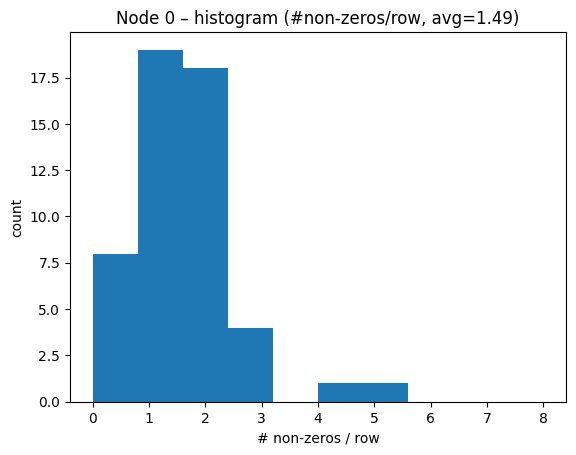

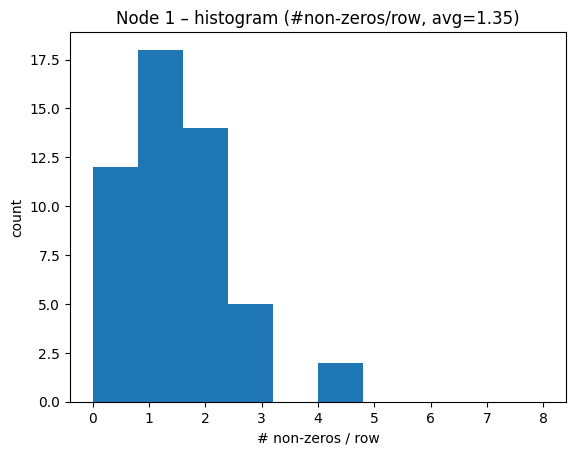

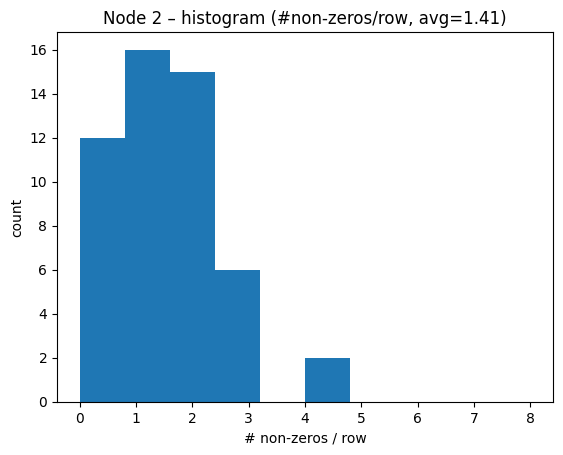

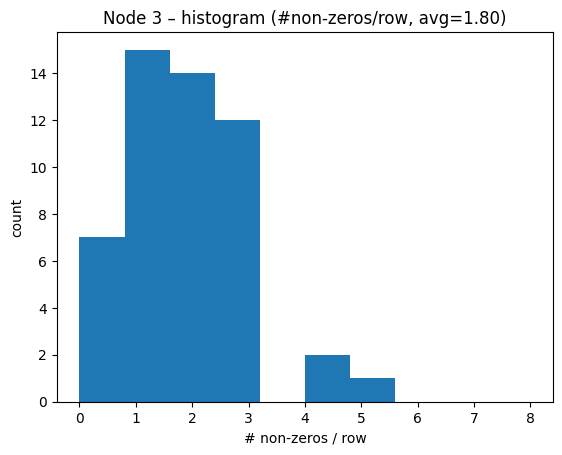

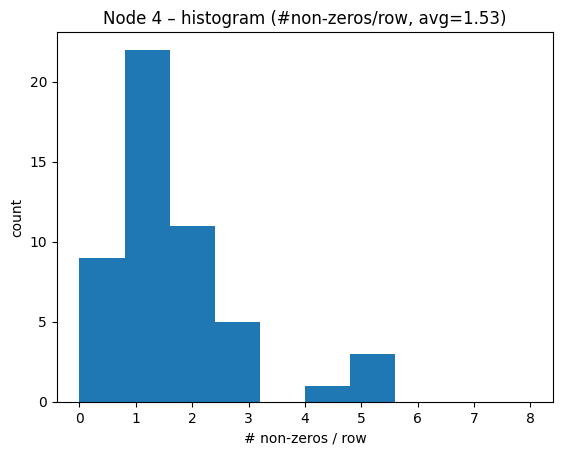

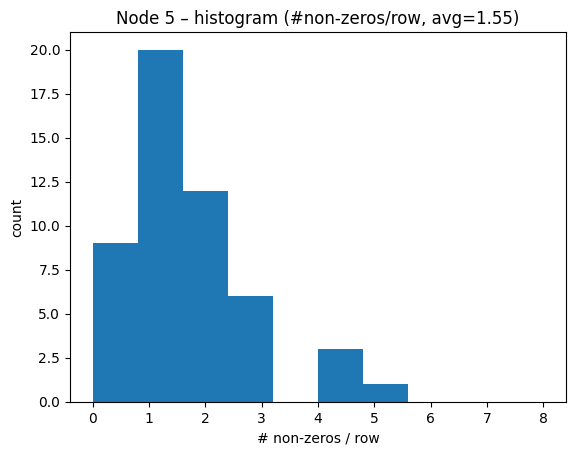

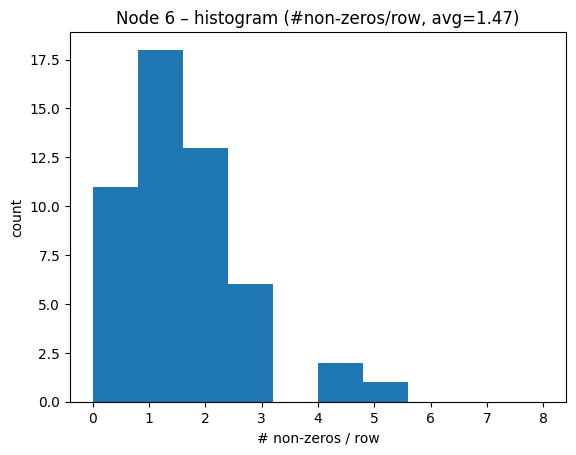

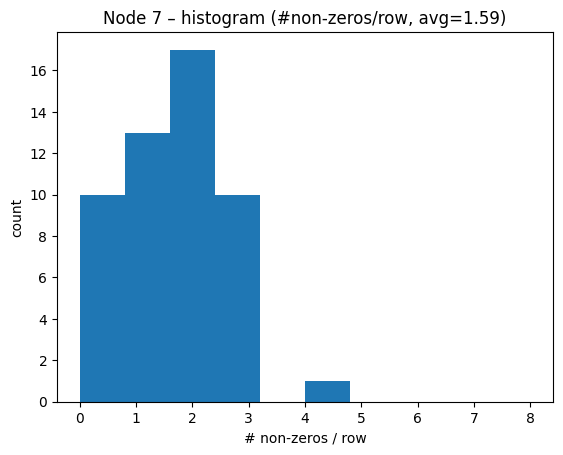

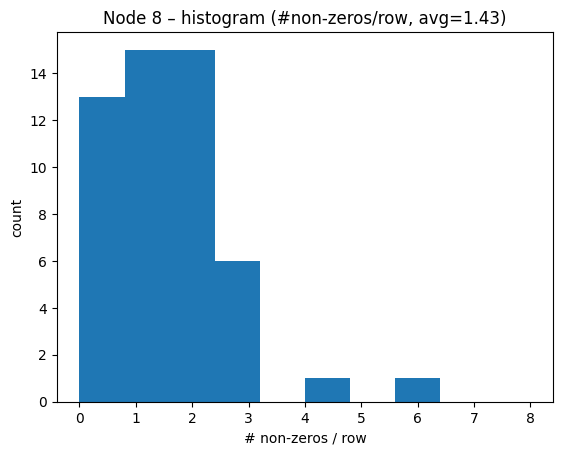

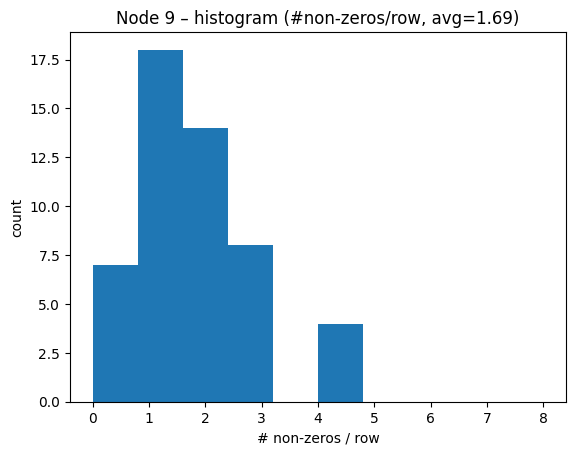

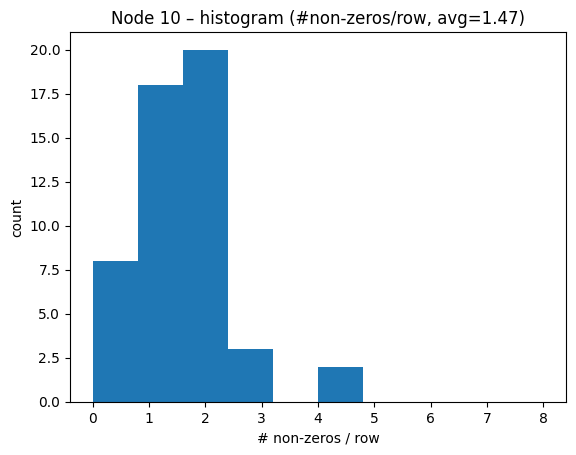

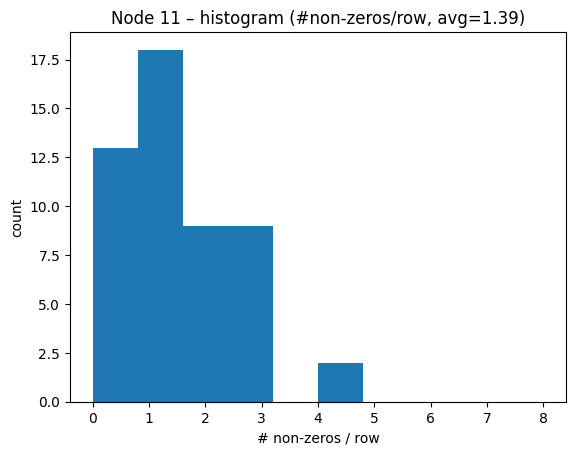

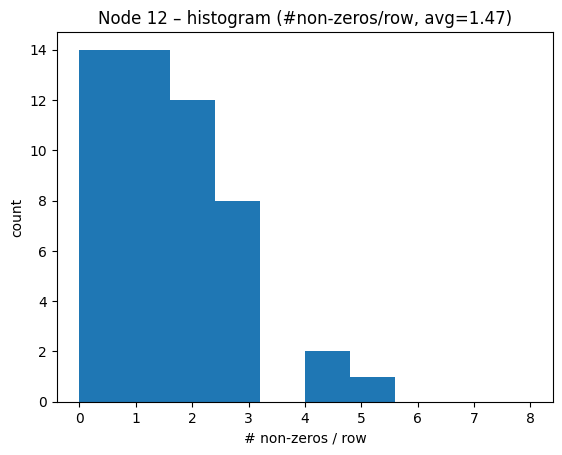

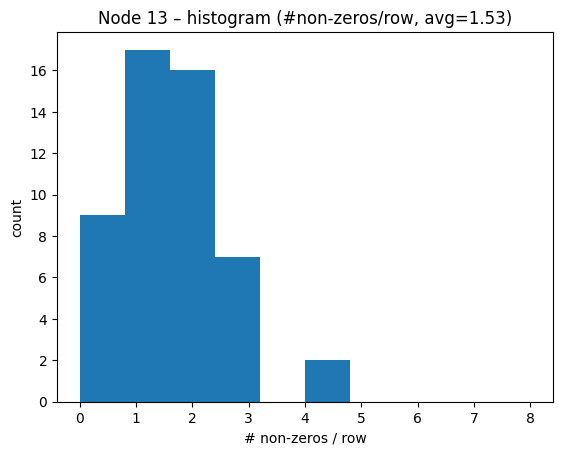

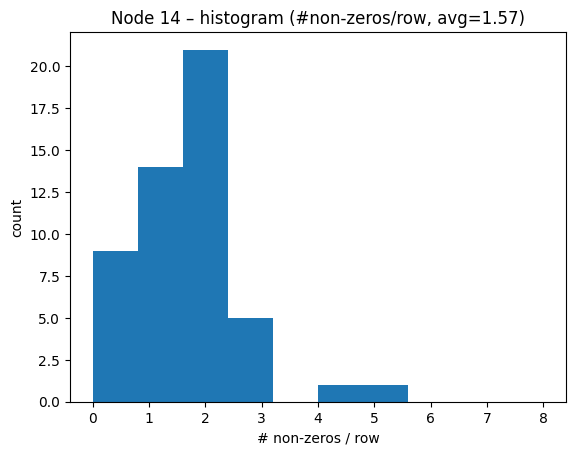

Only plotted 15 / 45 nodes' histograms.


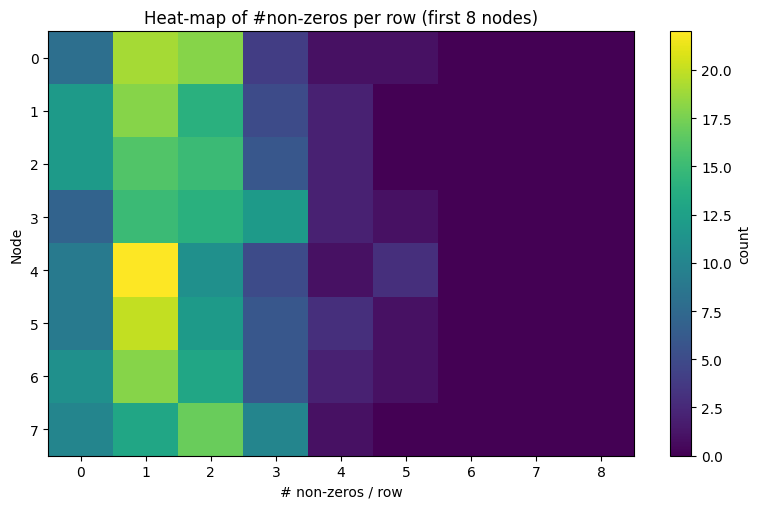

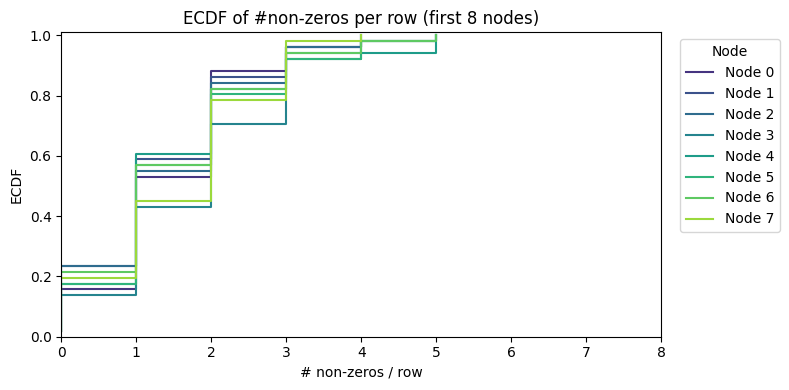

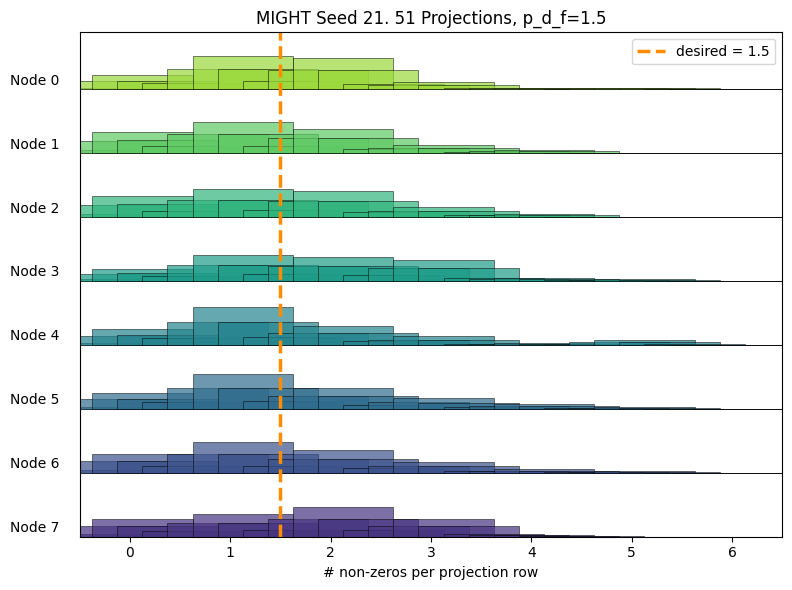

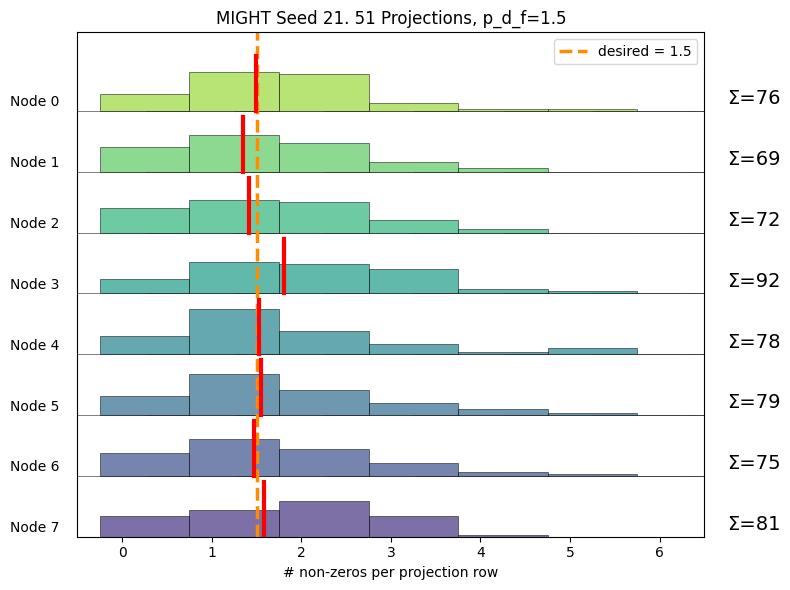

In [45]:
_ = parse_and_plot_matrices(file_path="../results/ydf_projection_matrices/projection_matrices_might_allow_empty_seed_21.txt", n_features=2523, ridgeplot_title="MIGHT Seed 21. 51 Projections, p_d_f=1.5")